In [14]:
from sklearn.linear_model import LogisticRegression
from sklearn.preprocessing import OneHotEncoder,StandardScaler
from sklearn.metrics import classification_report, confusion_matrix, roc_auc_score
from sklearn.pipeline import Pipeline
from sklearn.model_selection import GridSearchCV
from sklearn.svm import SVC
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# Train Data Loading

In [15]:
train_data = pd.read_excel('../_github/Data/train_data.xlsx')
train_data = train_data.convert_dtypes()
test_data = pd.read_excel('../_github/Data/test_data.xlsx')
test_data = test_data.convert_dtypes()

In [16]:
print(train_data.info())

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 36168 entries, 0 to 36167
Data columns (total 17 columns):
 #   Column        Non-Null Count  Dtype 
---  ------        --------------  ----- 
 0   y             36168 non-null  string
 1   age           36168 non-null  Int64 
 2   job           36168 non-null  string
 3   marital       36168 non-null  string
 4   education     36168 non-null  string
 5   default       36168 non-null  string
 6   balance       36168 non-null  Int64 
 7   housing       36168 non-null  string
 8   loan          36168 non-null  string
 9   contact       36168 non-null  string
 10  day_of_month  36168 non-null  Int64 
 11  month         36168 non-null  string
 12  duration      36168 non-null  Int64 
 13  campaign      36168 non-null  Int64 
 14  pdays         36168 non-null  Int64 
 15  previous      36168 non-null  Int64 
 16  poutcome      36168 non-null  string
dtypes: Int64(7), string(10)
memory usage: 4.9 MB
None


In [17]:
display(train_data.head())
train_data.shape,test_data.shape

,y,age,job,marital,education,default,balance,housing,loan,contact,day_of_month,month,duration,campaign,pdays,previous,poutcome
0,yes,66,retired,married,secondary,no,2048,no,no,cellular,27,aug,212,1,-1,0,Not Specified
1,no,49,admin.,single,primary,no,181,yes,no,Not Specified,8,may,161,3,-1,0,Not Specified
2,no,41,blue-collar,divorced,primary,no,-129,yes,no,cellular,18,may,176,1,-1,0,Not Specified
3,no,42,Not Specified,single,Not Specified,no,1316,no,no,Not Specified,5,jun,285,1,-1,0,Not Specified
4,no,45,services,married,secondary,no,1621,no,no,cellular,18,aug,122,8,-1,0,Not Specified


((36168, 17), (9043, 17))

# Categorical Modeling

In [18]:
categorical_cols = train_data.select_dtypes(include = 'string').columns
train_data[categorical_cols] = train_data[categorical_cols].astype('category')
cat_train_data = train_data[categorical_cols].copy()
test_data[categorical_cols] = test_data[categorical_cols].astype('category')
cat_test_data = test_data[categorical_cols].copy()

In [19]:
cat_train_data.head()

,y,job,marital,education,default,housing,loan,contact,month,poutcome
0,yes,retired,married,secondary,no,no,no,cellular,aug,Not Specified
1,no,admin.,single,primary,no,yes,no,Not Specified,may,Not Specified
2,no,blue-collar,divorced,primary,no,yes,no,cellular,may,Not Specified
3,no,Not Specified,single,Not Specified,no,no,no,Not Specified,jun,Not Specified
4,no,services,married,secondary,no,no,no,cellular,aug,Not Specified


In [20]:
cat_cols = cat_train_data.columns[1:]
target_col = "y"

In [21]:
# Evaluation helper
def print_metrics(y_true, y_pred, y_prob= None):
    print("Confusion Matrix:\n", confusion_matrix(y_true, y_pred))
    print("\nClassification Report:\n", classification_report(y_true, y_pred, digits=3))
    if y_prob is not None:
        print(f"ROC AUC: {roc_auc_score(y_true, y_prob):.4f}")

In [22]:
# One-hot encode categorical features
X_train = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).fit_transform(cat_train_data[cat_cols])
y_train = (cat_train_data['y'] == "yes").astype(int)

X_test = OneHotEncoder(handle_unknown = 'ignore', sparse_output = False).fit_transform(cat_test_data[cat_cols])
y_test = (cat_test_data['y'] == "yes").astype(int)

In [23]:
# Train logistic regression (with balanced class weights for fairness)
cat_model = LogisticRegression(max_iter=1000, class_weight='balanced')
cat_model.fit(X_train, y_train)

# Predict and evaluate
y_pred = cat_model.predict(X_test)
y_prob = cat_model.predict_proba(X_test)[:, 1]
print_metrics(y_test, y_pred, y_prob)

Confusion Matrix:
 [[6324 1662]
 [ 413  644]]

Classification Report:
               precision    recall  f1-score   support

           0      0.939     0.792     0.859      7986
           1      0.279     0.609     0.383      1057

    accuracy                          0.771      9043
   macro avg      0.609     0.701     0.621      9043
weighted avg      0.862     0.771     0.803      9043

ROC AUC: 0.7625


## Continuous Covariates

In [24]:
all_numeric_cols = ["age","balance","day_of_month","duration","campaign","pdays","previous"]

In [25]:
numeric_cols = ["age","balance","previous"]
y_pred = cat_model.predict(X_train)
y_prob = cat_model.predict_proba(X_train)[:, 1]
X_train = train_data[numeric_cols].copy()
X_train['cat_prob'] = y_prob
y_pred = cat_model.predict(X_test)
y_prob = cat_model.predict_proba(X_test)[:, 1]
X_test = test_data[numeric_cols].copy()
X_test['cat_prob'] = y_prob

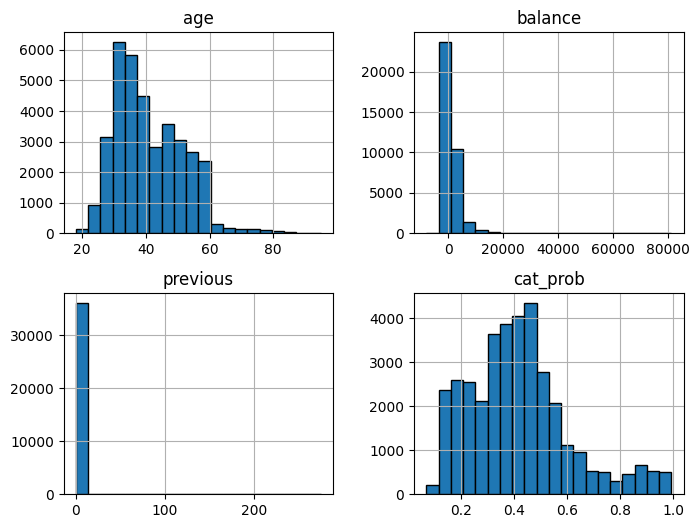

In [27]:
X_train.hist(bins = 20,edgecolor ='black',figsize=(8,6))
plt.show()

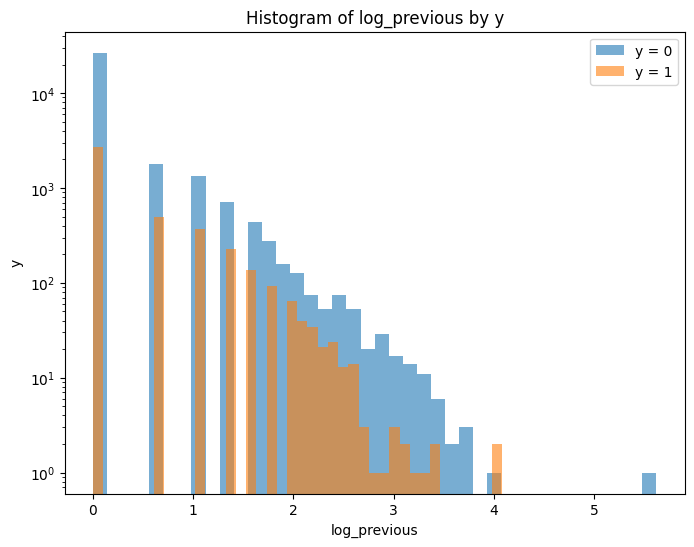

In [28]:
X_train['log_previous']=np.log1p(X_train['previous'])
X_test['log_previous']=np.log1p(X_test['previous'])
plt.figure(figsize=(8,6))
plt.hist(
    X_train.loc[y_train == 0, "log_previous"],
    bins=40,
    alpha=0.6,
    label="y = 0"
)
plt.hist(
    X_train.loc[y_train == 1, "log_previous"],
    bins=40,
    alpha=0.6,
    label="y = 1"
)
plt.title("Histogram of log_previous by y")
plt.xlabel("log_previous")
plt.ylabel("y")
plt.yscale('log')
plt.legend()
plt.show()


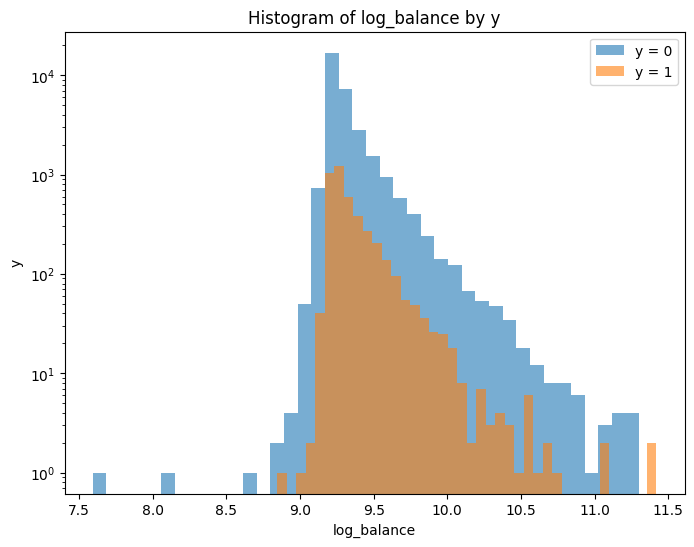

In [29]:
X_train["log_balance"] = np.log1p(X_train["balance"]+10000)
X_test["log_balance"] = np.log1p(X_test["balance"]+10000)

plt.figure(figsize=(8,6))
plt.hist(
    X_train.loc[y_train == 0, "log_balance"],
    bins=40,
    alpha=0.6,
    label="y = 0"
)
plt.hist(
    X_train.loc[y_train == 1, "log_balance"],
    bins=40,
    alpha=0.6,
    label="y = 1"
)
plt.title("Histogram of log_balance by y")
plt.xlabel("log_balance")
plt.ylabel("y")
plt.yscale('log')
plt.legend()
plt.show()


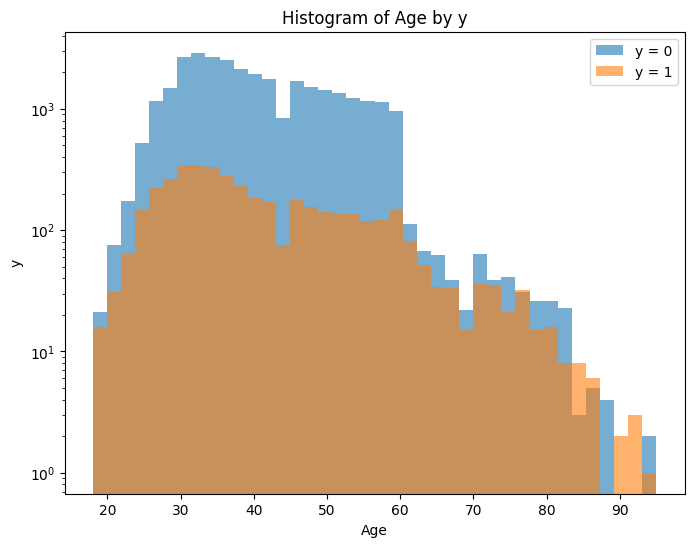

In [30]:
plt.figure(figsize=(8,6))
plt.hist(
    X_train.loc[y_train == 0, "age"],
    bins=40,
    alpha=0.6,
    label="y = 0"
)
plt.hist(
    X_train.loc[y_train == 1, "age"],
    bins=40,
    alpha=0.6,
    label="y = 1"
)
plt.title("Histogram of Age by y")
plt.xlabel("Age")
plt.ylabel("y")
plt.yscale('log')
plt.legend()
plt.show()

In [31]:
numvars = ['age','log_balance','log_previous','cat_prob']

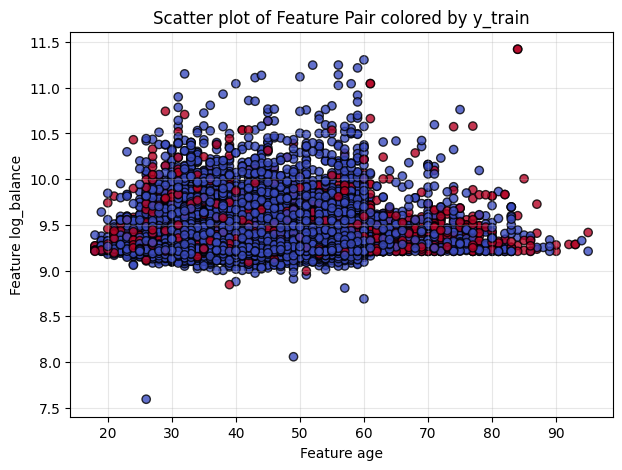

In [32]:
import matplotlib.pyplot as plt

# choose your variable indices
i = 0   # first feature index
j = 1   # second feature index

plt.figure(figsize=(7,5))

plt.scatter(X_train[numvars[i]], X_train[numvars[j]], 
            c=y_train, cmap="coolwarm", alpha=0.8, edgecolor="k")

plt.xlabel(f"Feature {numvars[i]}")
plt.ylabel(f"Feature {numvars[j]}")
plt.title("Scatter plot of Feature Pair colored by y_train")
plt.grid(True, alpha=0.3)
plt.show()


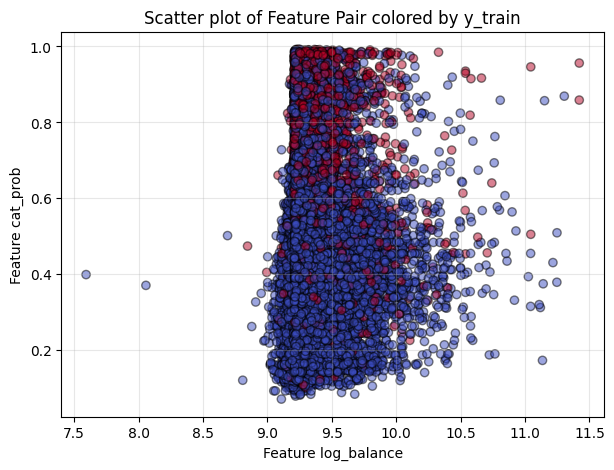

In [33]:
import matplotlib.pyplot as plt

# choose your variable indices
i = 1   # first feature index
j = 3   # second feature index

plt.figure(figsize=(7,5))

plt.scatter(X_train[numvars[i]], X_train[numvars[j]], 
            c=y_train, cmap="coolwarm", alpha=0.5, edgecolor="k")

plt.xlabel(f"Feature {numvars[i]}")
plt.ylabel(f"Feature {numvars[j]}")
plt.title("Scatter plot of Feature Pair colored by y_train")
plt.grid(True, alpha=0.3)
plt.show()

In [34]:
X_train.head()

,age,balance,previous,cat_prob,log_previous,log_balance
0,66,2048,0,0.539934,0.0,9.396737
1,49,181,0,0.205093,0.0,9.228377
2,41,-129,0,0.423813,0.0,9.197458
3,42,1316,0,0.387346,0.0,9.334061
4,45,1621,0,0.396860,0.0,9.360655


In [35]:
y_train.value_counts()

y
0    31936
1     4232
Name: count, dtype: int64

In [36]:
numvars = ['log_balance','cat_prob']
X_train = X_train[numvars].copy()
X_test = X_test[numvars].copy()

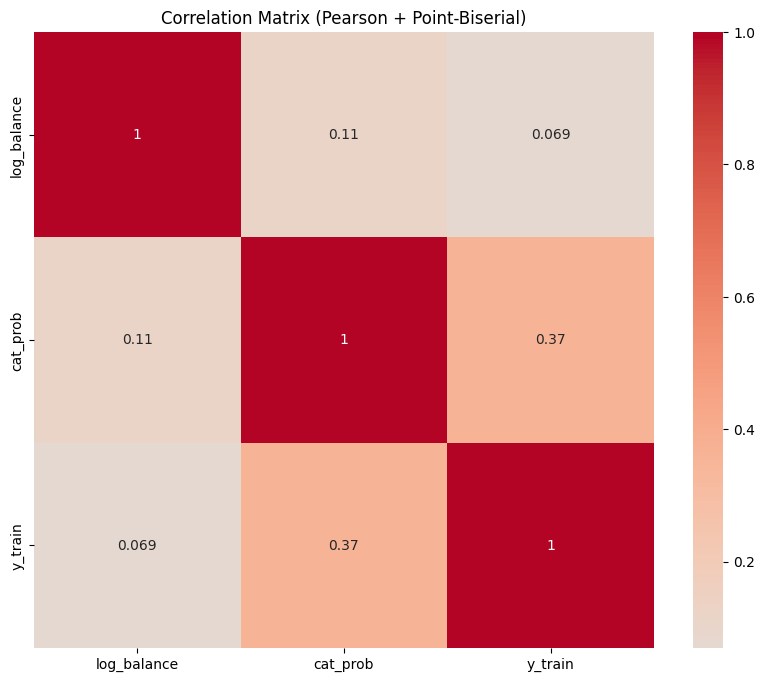

In [37]:
from scipy.stats import pointbiserialr

pb_corr = {}

for col in X_train.columns:
    r, p = pointbiserialr(y_train, X_train[col].astype(float))
    pb_corr[col] = r

pb_corr = pd.Series(pb_corr, name='y_train')

num_corr = X_train.corr()
corr = num_corr.copy()
corr['y_train'] = pb_corr
corr.loc['y_train'] = corr['y_train']
corr.loc['y_train','y_train'] = 1.0

plt.figure(figsize=(10,8))
sns.heatmap(corr, cmap='coolwarm', center=0, annot=True)
plt.title("Correlation Matrix (Pearson + Point-Biserial)")
plt.show()

In [38]:
svm_model = Pipeline([
    ("scaler", StandardScaler()),
    ("svc", SVC(kernel="linear", C=1.0, class_weight="balanced"))
])

svm_model.fit(X_train, y_train)

y_pred = svm_model.predict(X_test)
print_metrics(y_test, y_pred)

Confusion Matrix:
 [[6765 1221]
 [ 484  573]]

Classification Report:
               precision    recall  f1-score   support

           0      0.933     0.847     0.888      7986
           1      0.319     0.542     0.402      1057

    accuracy                          0.811      9043
   macro avg      0.626     0.695     0.645      9043
weighted avg      0.861     0.811     0.831      9043



In [39]:
X_train.shape,X_test.shape

((36168, 2), (9043, 2))

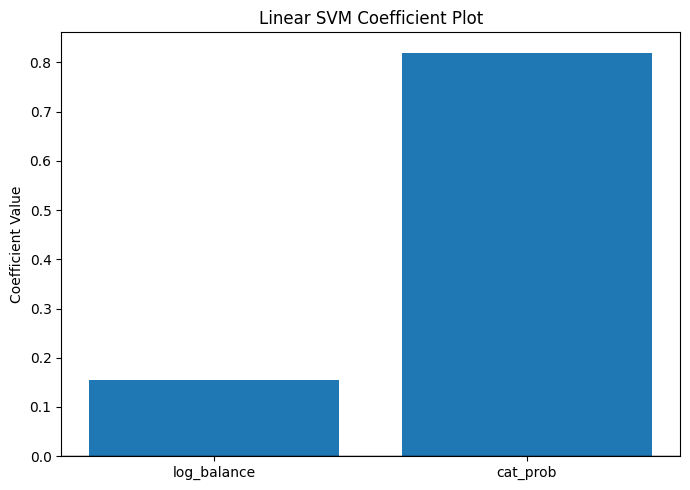

In [40]:
import numpy as np
import matplotlib.pyplot as plt

# Extract coefficients
coef = svm_model.named_steps["svc"].coef_[0]

plt.figure(figsize=(7,5))
plt.bar(numvars, coef)
plt.axhline(0, color='black', linewidth=1)
plt.title("Linear SVM Coefficient Plot")
plt.ylabel("Coefficient Value")
plt.tight_layout()
plt.show()

In [41]:
# Coefficient vector w
w = svm_model.named_steps["svc"].coef_[0]

# Margin width
margin = 2 / np.linalg.norm(w)

print("Margin width:", margin)


Margin width: 2.3967070709708063


c:\Users\chakr\AppData\Local\Programs\Python\Python310\lib\site-packages\sklearn\utils\validation.py:2749: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


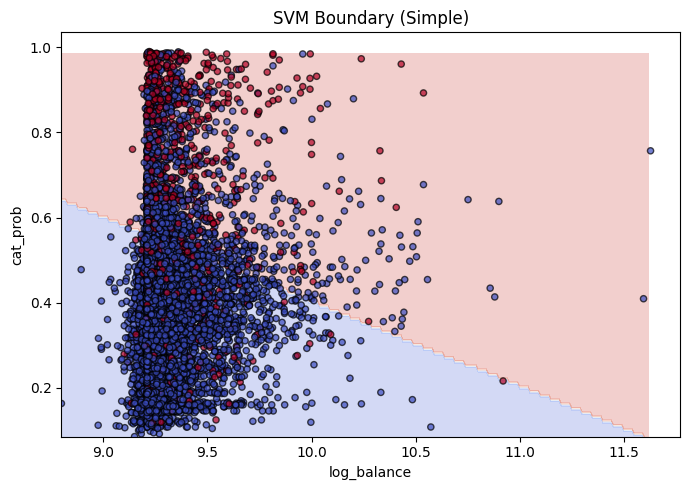

In [42]:
scaler = svm_model.named_steps["scaler"]
svc     = svm_model.named_steps["svc"]
def plot_decision_boundary(i, j, X, y, model, scaler):
    # only 2 variables
    xi = X[numvars[i]]
    xj = X[numvars[j]]

    h = 0.01
    x_min, x_max = xi.min(), xi.max()
    y_min, y_max = xj.min(), xj.max()

    xx, yy = np.meshgrid(np.arange(x_min, x_max, h),
                         np.arange(y_min, y_max, h))

    mesh_points = np.c_[xx.ravel(), yy.ravel()]
    mesh_scaled = scaler.transform(mesh_points)

    Z = model.predict(mesh_scaled).reshape(xx.shape)

    plt.figure(figsize=(7, 5))
    plt.contourf(xx, yy, Z, alpha=0.25, cmap="coolwarm")

    plt.scatter(xi, xj, c=y, cmap="coolwarm", s=20, edgecolor="k", alpha=0.7)

    plt.xlabel(numvars[i])
    plt.ylabel(numvars[j])
    plt.title("SVM Boundary (Simple)")
    plt.tight_layout()
    plt.show()

plot_decision_boundary(0,1,X_test, y_test, svc, scaler)